In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as mt
from sklearn.model_selection import StratifiedShuffleSplit
import sklearn.preprocessing as pre

In [2]:
table = pd.read_csv('database.csv',na_values=
                    ['NA','NaN','.','?',' ','#VALUE!']).dropna(
                    subset=['Act Fis']).dropna(axis=1)

#'EDADDEC','EDADCOD','PESO','TALLA', 'TALLA m','IMC'

"""'SEXO', 'EDADDEC',
       'EDADCOD', 'PESO', 'TALLA', 'TALLA m', 'CBRAZOD', 'CBRAZOI', 'TRICEPSD',
       'TRICEPSI', 'IMC', 'Contextura'"""

X = pre.scale(table.drop(columns=['Act Fis','Muestra','FICHA',
                                  'ESC','Procedencia','EDADDEC','PESO', 'TALLA',
                                  'CBRAZOD', 'CBRAZOI', 'TRICEPSD',
                                  'TRICEPSI', 'IMC']).to_numpy().astype(float))
y = table['Act Fis'].to_numpy()

le = pre.LabelEncoder()
le.fit(y)
y = le.transform(y)

In [3]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
for train_index, test_index in sss.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [4]:
param_nn = {'alpha': [0.0001], 'hidden_layer_sizes': [(200,100,50,)], 'max_iter':[10000]}
nn = MLPClassifier()
cv_nn = GridSearchCV(nn,param_nn,cv=5)
cv_nn.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=None, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=

In [6]:
predicted_nn = cv_nn.predict(X_test)
accuracy_nn = mt.accuracy_score(y_test,predicted_nn)
print(accuracy_nn)
precision = mt.precision_score(y_test,predicted_nn)
print(precision)
recall = mt.recall_score(y_test,predicted_nn)
print(recall)

0.8347107438016529
0.84375
0.9


In [6]:
pos = 0
neg = 0
for i in range(y_test.shape[0]):
    if y_test[i] == 1:
        pos += 1
    elif y_test[i] == 0:
        neg += 1
        
print(pos)
print(neg)

450
276


In [7]:
table.columns

Index(['Muestra', 'Procedencia', 'Act Fis', 'FICHA', 'ESC', 'SEXO', 'EDADDEC',
       'EDADCOD', 'PESO', 'TALLA', 'TALLA m', 'CBRAZOD', 'CBRAZOI', 'TRICEPSD',
       'TRICEPSI', 'IMC', 'Contextura'],
      dtype='object')

In [8]:
print(X.shape)

(3628, 6)


## Selección de atributos

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets, models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [5]:
class Encoder(nn.Module):
    """ Encoder that reduces an input from 12 dimensions to 6"""
    
    def __init__(self):
        super(Encoder,self).__init__()
        self.fc = nn.Linear(12,4)
        
    def forward(self,input):
        return F.relu(self.fc(input))

In [6]:
class Decoder(nn.Module):
    """ Decoder that reconstructs a 12-dimensional vector from a 6-dimensional input """
    
    def __init__(self):
        super(Decoder,self).__init__()
        self.fc = nn.Linear(4,12)
        
    def forward(self,input):
        return self.fc(input)

In [7]:
def train(encoder,decoder,loader,enc_optimizer,dec_optimizer,criterion,epochs,device):
    """Trains the given model
    
    Args:
        encoder (nn.Module inherited class) : encoder used
        decoder (nn.Module inherited class) : decoder used
        loader (data.DataLoader) : loader used for training 
        enc_optimizer (optim): encoder optimizer
        dec_optimizer (optim): decoder optimizer
        criterion (torch.nn criterion): criterion used for the optimization
        epochs (int): # epochs for training 
        device (torch.device) : device where the computation will take place 
    """
    epoch_values = [] 
    for j in range(epochs):

        running_loss = 0.0
        loss_values = 0
        num_batches = 0
        
        for i, data in enumerate(loader, 0):
    
            inputs = data.to(device)
            
            #We clean the gradients
            enc_optimizer.zero_grad()
            dec_optimizer.zero_grad()
            
            compressed = encoder(inputs) #Encode
            outputs = decoder(compressed) #Decode
            
            loss = criterion(outputs,inputs) #calculate loss
            loss.backward() #backpropagate
            
            #Update weights 
            enc_optimizer.step() 
            dec_optimizer.step()

            running_loss += loss.item()
            loss_values += loss.item()
            num_batches += 1
            if i % 5000 == 4999:
                print('[%d, %5d] loss: %.3f' %
                          (j + 1, i + 1, running_loss / 5000))
                running_loss = 0.0
                
        epoch_values.append(loss_values / num_batches)
                
    print("Finished training") 
    fig, ax = plt.subplots()
    ax.plot(np.array(epoch_values), 'r')
    ax.set(xlabel='Number of epochs', ylabel='MSE',title='Training Error')
    plt.savefig('training_error.png')
    plt.show()

In [8]:
def testing(encoder,decoder,loader,device,remove_outliers=False):
    
    """Tests the given model
    
   Args:
        encoder (nn.Module inherited class) : encoder used
        decoder (nn.Module inherited class) : decoder used
        loader (data.DataLoader) : loader used for testing
        device (torch.device) : device where the computation will take place
        remove_outliers (Bool): flag that determines if the outliers will be removed from the plots 
                                (True) or not (False)
    """

    error_list = []           
    with torch.no_grad():
        for data in loader:
            inputs = data.to(device)
            compressed = encoder(inputs) #Encodes 
            outputs = decoder(compressed) # Decodes
            #Calculate the difference between original and reconstructed instances
            batch_error = inputs - outputs / inputs 
            error_list.append(batch_error)

    attributes = ['SEXO', 'EDADDEC',
       'EDADCOD', 'PESO', 'TALLA', 'TALLA m', 'CBRAZOD', 'CBRAZOI', 'TRICEPSD',
       'TRICEPSI', 'IMC', 'Contextura']
    
    error = torch.cat(error_list,0).numpy()
    if remove_outliers:
        error = error[~is_outlier(error)] #Removes outliers
    instances = range(error.shape[0])
    var_index = 0
    str_outlier = "_without_outliers" if remove_outliers else ""
    
    for i in range(len(attributes)):
        fig, ax = plt.subplots()
        ax.scatter(instances,error[:,var_index])
        ax.set(xlabel='Instances', ylabel='original - uncompressed / original', 
                         title='Variable ' + attributes[var_index])
        plt.savefig('error_' + attributes[var_index] + str_outlier + '.png')
        plt.show()
        var_index += 1


In [10]:
# Taken from : https://stackoverflow.com/questions/11882393/matplotlib-disregard-outliers-when-plotting
# Credits: Joe Kington

def is_outlier(points, thresh=3):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

In [11]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [12]:
X_train_tensor = torch.from_numpy(X_train).float()
X_test_tensor = torch.from_numpy(X_test).float()
trainloader = DataLoader(X_train_tensor, batch_size=5, shuffle=True)
testloader = DataLoader(X_test_tensor, batch_size=5, shuffle=True)
encoder = Encoder().to(device)
decoder = Decoder().to(device)
criterion = nn.MSELoss()
enc_optimizer = optim.Adam(encoder.parameters())
dec_optimizer = optim.Adam(decoder.parameters())

Finished training


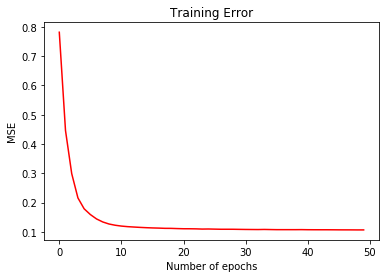

In [13]:
train(encoder,decoder,trainloader,enc_optimizer,dec_optimizer,criterion,50,device)

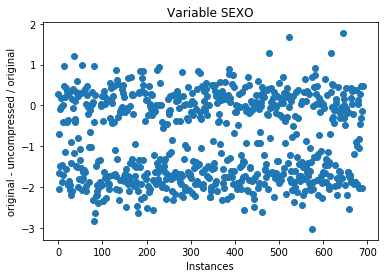

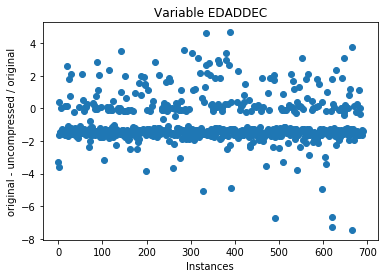

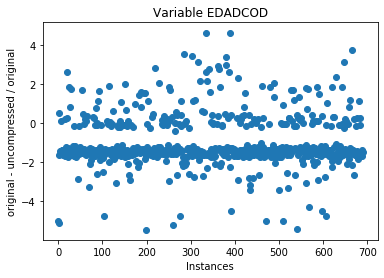

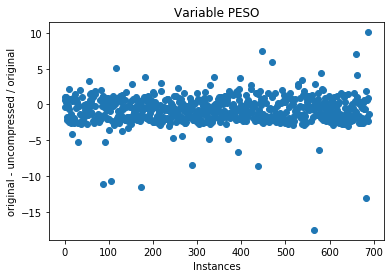

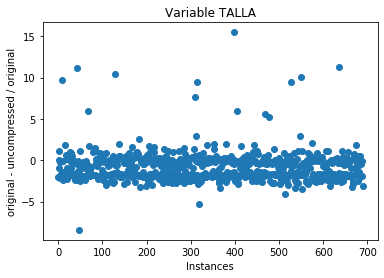

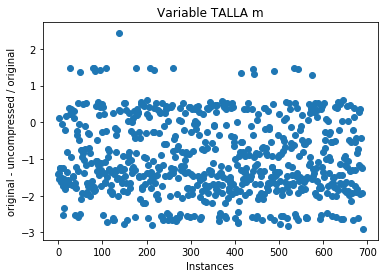

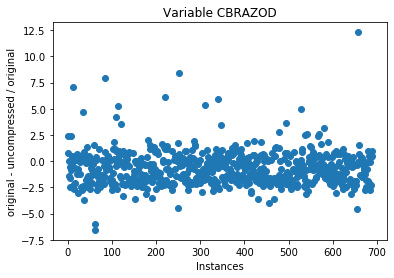

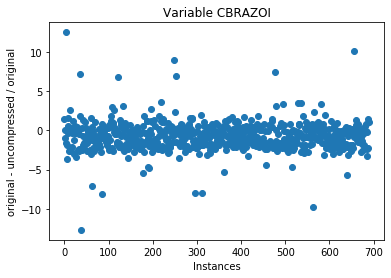

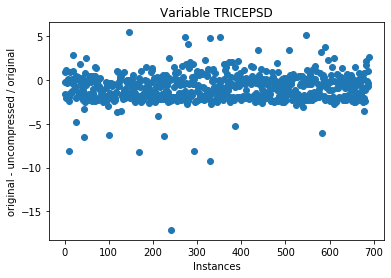

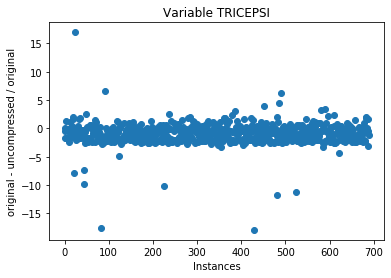

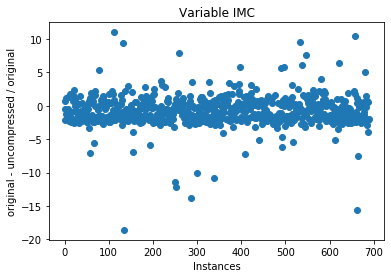

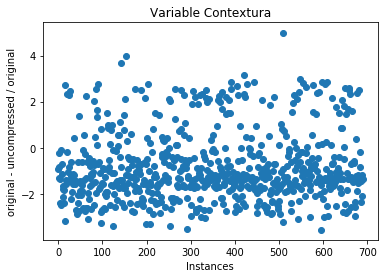

In [14]:
testing(encoder,decoder,testloader,device,True)